### Preparations

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# need in final version
import glob

# may not need in final version
import numpy as np
import nibabel as nib
import seaborn as sns
import os
import matplotlib.pyplot as plt
import analysis.utils as from_utils
from tueplots import fonts
import pydicom

## T1w and T2w

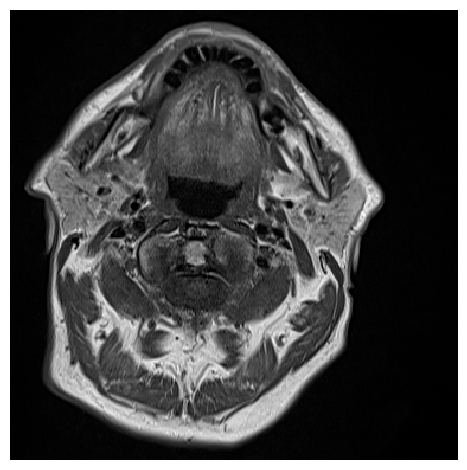

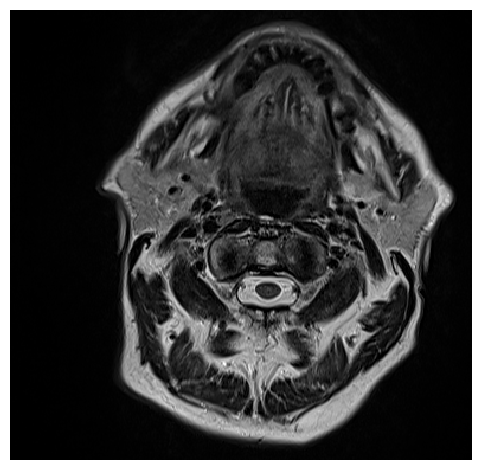

In [89]:
dir_out = f'../../Thesis/theory'
t1_path = '../dataA/raw/EMIN_1048/MRIdata/EMIN_1048_T1.nii'
t2_paths = glob.glob('../dataA/raw/EMIN_1048/MRIdata/T2_TSE_TRA_448_P2_0008/*.IMA')
slice = 8
x_min, x_max = 70, 400
y_min, y_max = 50, 430
space = 60

# Load and sort data
t1_slice = nib.load(t1_path).get_fdata()[:, :, slice]


t2_unsorted_files = []
for t2_path in t2_paths:
    dataset = pydicom.dcmread(t2_path)
    slice_loc = round(dataset.get("SliceLocation","NA"), ndigits = 3)
    t2_unsorted_files.append([dataset, slice_loc])
t2_sorted_files = sorted(t2_unsorted_files, key = lambda unsorted_file: unsorted_file[1])
t2_slice = t2_sorted_files[slice][0].pixel_array


fig, ax = plt.subplots(frameon=False)
im = ax.imshow(t1_slice.T[y_min:y_max, x_min:x_max+space], cmap='gray', interpolation='none')
ax.axis("off")
fig.tight_layout()
plt.savefig(os.path.join(dir_out, f't1_hnc.pdf'), bbox_inches = 'tight')   
plt.savefig(os.path.join(dir_out, f't1_nhc.svg'))  

fig, ax = plt.subplots(frameon=False)
im = ax.imshow(t2_slice[y_min:y_max, x_min-space:x_max], cmap='gray', interpolation='none')
ax.axis("off")
fig.tight_layout()
plt.savefig(os.path.join(dir_out, f't2_hnc.pdf'), bbox_inches = 'tight')   
plt.savefig(os.path.join(dir_out, f't2_nhc.svg'))  


## DWI

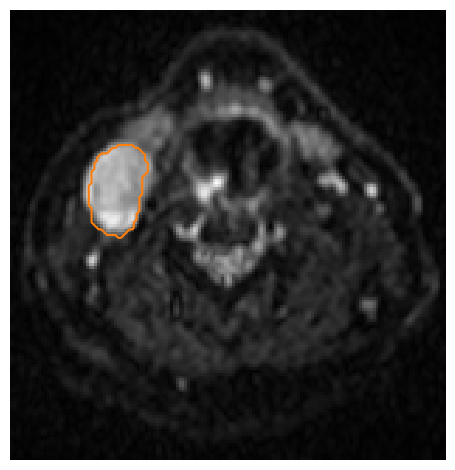

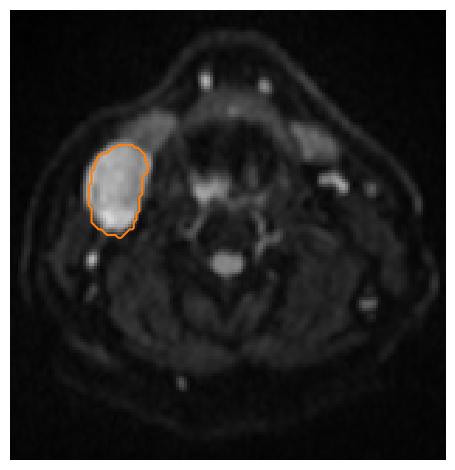

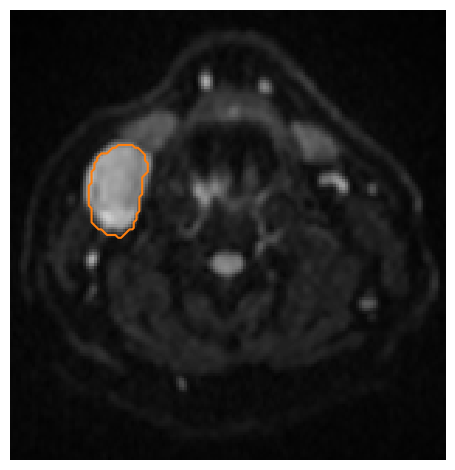

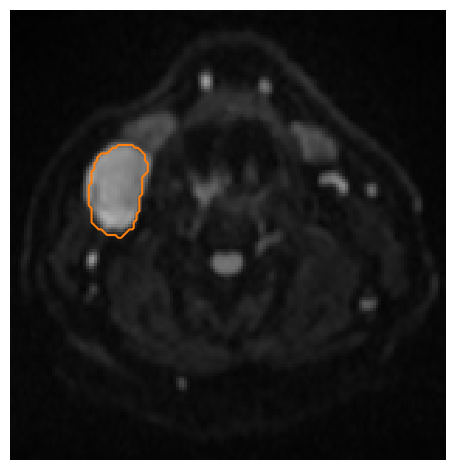

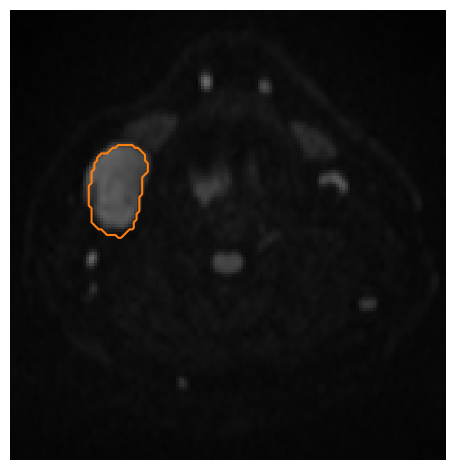

In [10]:

dataset_name = 'dataA'
patient_id = 'EMIN_1022'
mask_name = 'GTVn1'
dir_out = f'../../Thesis/theory'

levels = np.array([1])



dwi_4d_fname = glob.glob(f'../{dataset_name}/preprocessed/{patient_id}/dwi_4d/*.nii')[0]
bvals_fname = f'../{dataset_name}/preprocessed/{patient_id}/bvals.npy'
mask_fname = f'../{dataset_name}/preprocessed/{patient_id}/resampled_masks/{mask_name}/sorted_by_bval/resampled_mask_b0.nii'

dwi_4d_data = nib.load(dwi_4d_fname).get_fdata()
bvals = np.load(bvals_fname)
mask_data = nib.load(mask_fname).get_fdata()

z = np.argmax(np.sum(mask_data, axis=(0,1)))
max_S = np.max(dwi_4d_data[:, :, z, 0])


for i, bval in enumerate(bvals):
    dwi_data_slice = dwi_4d_data[110:265, 40:200, z, i] # hardcoded coordinated to crop image
    mask_data_slice = mask_data[110:265, 40:200, z]*2     # hardcoded coordinated to crop image

    fig, ax = plt.subplots(frameon=False)
    im = ax.imshow(dwi_data_slice.T, cmap='gray', vmin=0, vmax=max_S, interpolation='none')
    cs = ax.contour(mask_data_slice.T, levels, colors='C1', corner_mask=False)

    ax.axis("off")
    fig.tight_layout()

    plt.savefig(os.path.join(dir_out, f'dwi_b{bval}_wmask.pdf'), bbox_inches = 'tight')   
    plt.savefig(os.path.join(dir_out, f'dwi_b{bval}_wmaks.svg'))  


## Training method of $\text{DNN}_{\text{SSL}}$

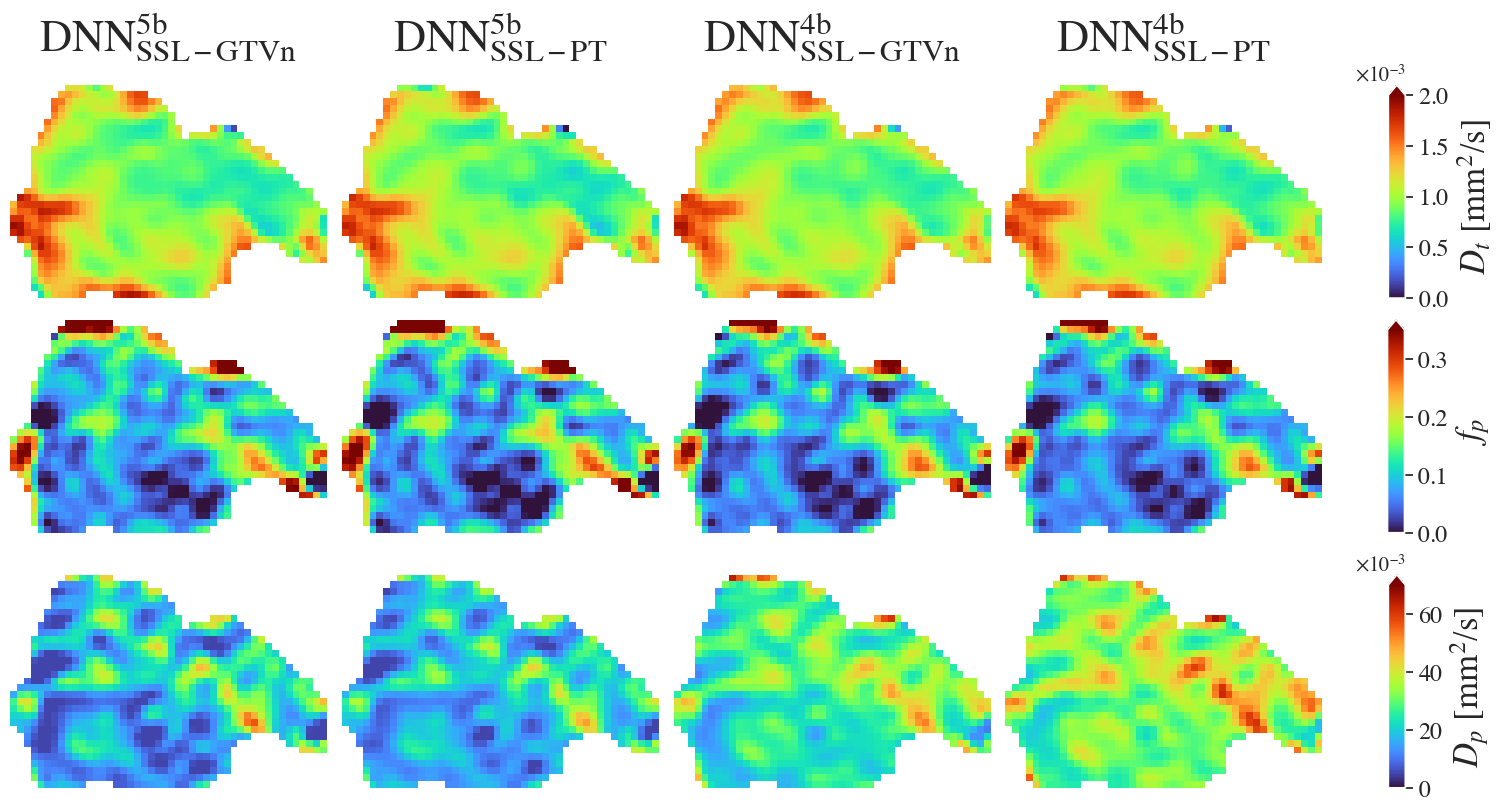

In [7]:
# Input
patient_id = 'EMIN_1081' #'EMIN_1068' #'EMIN_1099'
mask_name = 'GTVn1'

dir_in_a5 = f'../dataA/output/patientsA_LOO_a_b5/{patient_id}'
dir_in_a4 = f'../dataA/output/patientsA_LOO_a_b4/{patient_id}'
dir_in_b5 = f'../dataA/output/patientsA_LOO_b_b5/{patient_id}'
dir_in_b4 = f'../dataA/output/patientsA_LOO_b_b4/{patient_id}'
dir_out = f'../dataA/plots/{patient_id}/{mask_name}'



# Preprocessing
bvals_fname = f'../dataA/preprocessed/{patient_id}/bvals.npy'
mask_fname = f'../dataA/preprocessed/{patient_id}/resampled_masks/{mask_name}/sorted_by_bval/resampled_mask_b0.nii'

bvals = np.load(bvals_fname)
mask_data = nib.load(mask_fname).get_fdata()

z = np.argmax(np.sum(mask_data, axis=(0,1)))
mask_slice = mask_data[:, :, z]

x_indecies, y_indecies = np.where(mask_slice == 1)
x_min, x_max = np.min(x_indecies), np.max(x_indecies)
y_min, y_max = np.min(y_indecies), np.max(y_indecies)


mask_slice_dim_mask = mask_data[x_min:x_max, y_min:y_max, z]


Dt_dnn_slf_a5 = nib.load(os.path.join(dir_in_a5, f'dnn_slf/Dt.nii.gz')).get_fdata()
Fp_dnn_slf_a5 = nib.load(os.path.join(dir_in_a5, f'dnn_slf/fp.nii.gz')).get_fdata()
Dp_dnn_slf_a5 = nib.load(os.path.join(dir_in_a5, f'dnn_slf/Dp.nii.gz')).get_fdata()
S0_dnn_slf_a5 = nib.load(os.path.join(dir_in_a5, f'dnn_slf/S0.nii.gz')).get_fdata()
rmse_dnn_slf_a5 = nib.load(os.path.join(dir_in_a5, f'dnn_slf/rmse.nii.gz')).get_fdata()

Dt_dnn_slf_a5_masked = np.multiply(Dt_dnn_slf_a5, mask_data)
Fp_dnn_slf_a5_masked = np.multiply(Fp_dnn_slf_a5, mask_data)
Dp_dnn_slf_a5_masked = np.multiply(Dp_dnn_slf_a5, mask_data)
S0_dnn_slf_a5_masked = np.multiply(S0_dnn_slf_a5, mask_data)
rmse_dnn_slf_a5_masked =np.multiply(rmse_dnn_slf_a5, mask_data)

Dt_dnn_slf_a5_dim_mask = Dt_dnn_slf_a5_masked[x_min:x_max, y_min:y_max, z]
Fp_dnn_slf_a5_dim_mask = Fp_dnn_slf_a5_masked[x_min:x_max, y_min:y_max, z]
Dp_dnn_slf_a5_dim_mask = Dp_dnn_slf_a5_masked[x_min:x_max, y_min:y_max, z]
S0_dnn_slf_a5_dim_mask = S0_dnn_slf_a5_masked[x_min:x_max, y_min:y_max, z]
rmse_dnn_slf_a5_dim_mask = rmse_dnn_slf_a5_masked[x_min:x_max, y_min:y_max, z]


Dt_dnn_slf_a4 = nib.load(os.path.join(dir_in_a4, f'dnn_slf/Dt.nii.gz')).get_fdata()
Fp_dnn_slf_a4 = nib.load(os.path.join(dir_in_a4, f'dnn_slf/fp.nii.gz')).get_fdata()
Dp_dnn_slf_a4 = nib.load(os.path.join(dir_in_a4, f'dnn_slf/Dp.nii.gz')).get_fdata()
S0_dnn_slf_a4 = nib.load(os.path.join(dir_in_a4, f'dnn_slf/S0.nii.gz')).get_fdata()
rmse_dnn_slf_a4 = nib.load(os.path.join(dir_in_a4, f'dnn_slf/rmse.nii.gz')).get_fdata()

Dt_dnn_slf_a4_masked = np.multiply(Dt_dnn_slf_a4, mask_data)
Fp_dnn_slf_a4_masked = np.multiply(Fp_dnn_slf_a4, mask_data)
Dp_dnn_slf_a4_masked = np.multiply(Dp_dnn_slf_a4, mask_data)
S0_dnn_slf_a4_masked = np.multiply(S0_dnn_slf_a4, mask_data)
rmse_dnn_slf_a4_masked =np.multiply(rmse_dnn_slf_a4, mask_data)

Dt_dnn_slf_a4_dim_mask = Dt_dnn_slf_a4_masked[x_min:x_max, y_min:y_max, z]
Fp_dnn_slf_a4_dim_mask = Fp_dnn_slf_a4_masked[x_min:x_max, y_min:y_max, z]
Dp_dnn_slf_a4_dim_mask = Dp_dnn_slf_a4_masked[x_min:x_max, y_min:y_max, z]
S0_dnn_slf_a4_dim_mask = S0_dnn_slf_a4_masked[x_min:x_max, y_min:y_max, z]
rmse_dnn_slf_a4_dim_mask = rmse_dnn_slf_a4_masked[x_min:x_max, y_min:y_max, z]


Dt_dnn_slf_b5 = nib.load(os.path.join(dir_in_b5, f'dnn_slf/Dt.nii.gz')).get_fdata()
Fp_dnn_slf_b5 = nib.load(os.path.join(dir_in_b5, f'dnn_slf/fp.nii.gz')).get_fdata()
Dp_dnn_slf_b5 = nib.load(os.path.join(dir_in_b5, f'dnn_slf/Dp.nii.gz')).get_fdata()
S0_dnn_slf_b5 = nib.load(os.path.join(dir_in_b5, f'dnn_slf/S0.nii.gz')).get_fdata()
rmse_dnn_slf_b5 = nib.load(os.path.join(dir_in_b5, f'dnn_slf/rmse.nii.gz')).get_fdata()

Dt_dnn_slf_b5_masked = np.multiply(Dt_dnn_slf_b5, mask_data)
Fp_dnn_slf_b5_masked = np.multiply(Fp_dnn_slf_b5, mask_data)
Dp_dnn_slf_b5_masked = np.multiply(Dp_dnn_slf_b5, mask_data)
S0_dnn_slf_b5_masked = np.multiply(S0_dnn_slf_b5, mask_data)
rmse_dnn_slf_b5_masked =np.multiply(rmse_dnn_slf_b5, mask_data)

Dt_dnn_slf_b5_dim_mask = Dt_dnn_slf_b5_masked[x_min:x_max, y_min:y_max, z]
Fp_dnn_slf_b5_dim_mask = Fp_dnn_slf_b5_masked[x_min:x_max, y_min:y_max, z]
Dp_dnn_slf_b5_dim_mask = Dp_dnn_slf_b5_masked[x_min:x_max, y_min:y_max, z]
S0_dnn_slf_b5_dim_mask = S0_dnn_slf_b5_masked[x_min:x_max, y_min:y_max, z]
rmse_dnn_slf_b5_dim_mask = rmse_dnn_slf_b5_masked[x_min:x_max, y_min:y_max, z]


Dt_dnn_slf_b4 = nib.load(os.path.join(dir_in_b4, f'dnn_slf/Dt.nii.gz')).get_fdata()
Fp_dnn_slf_b4 = nib.load(os.path.join(dir_in_b4, f'dnn_slf/fp.nii.gz')).get_fdata()
Dp_dnn_slf_b4 = nib.load(os.path.join(dir_in_b4, f'dnn_slf/Dp.nii.gz')).get_fdata()
S0_dnn_slf_b4 = nib.load(os.path.join(dir_in_b4, f'dnn_slf/S0.nii.gz')).get_fdata()
rmse_dnn_slf_b4 = nib.load(os.path.join(dir_in_b4, f'dnn_slf/rmse.nii.gz')).get_fdata()

Dt_dnn_slf_a4_masked = np.multiply(Dt_dnn_slf_b4, mask_data)
Fp_dnn_slf_a4_masked = np.multiply(Fp_dnn_slf_b4, mask_data)
Dp_dnn_slf_a4_masked = np.multiply(Dp_dnn_slf_b4, mask_data)
S0_dnn_slf_a4_masked = np.multiply(S0_dnn_slf_b4, mask_data)
rmse_dnn_slf_a4_masked =np.multiply(rmse_dnn_slf_b4, mask_data)

Dt_dnn_slf_b4_dim_mask = Dt_dnn_slf_a4_masked[x_min:x_max, y_min:y_max, z]
Fp_dnn_slf_b4_dim_mask = Fp_dnn_slf_a4_masked[x_min:x_max, y_min:y_max, z]
Dp_dnn_slf_b4_dim_mask = Dp_dnn_slf_a4_masked[x_min:x_max, y_min:y_max, z]
S0_dnn_slf_b4_dim_mask = S0_dnn_slf_a4_masked[x_min:x_max, y_min:y_max, z]
rmse_dnn_slf_b4_dim_mask = rmse_dnn_slf_a4_masked[x_min:x_max, y_min:y_max, z]



# Preparations
sns.set_theme()
params = {'axes.labelsize': 20,
          'axes.titlesize': 22.5,
          'axes.grid': False,
          'image.cmap': 'turbo',
          'xtick.labelsize': 15,
          'ytick.labelsize': 15,
          'savefig.format': 'pdf'
          }
plt.rcParams.update(fonts.neurips2021())
plt.rcParams.update(params)

alpha = mask_slice_dim_mask
cbformat_Dt = from_utils.OOMFormatter(-3, "%.1f")
cbformat_Dp = from_utils.OOMFormatter(-3, "%.0f")
extend_max = 'max'



#Plotting

fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize=(15, 8), constrained_layout = True)
[(ax00, ax01, ax02, ax03), (ax10, ax11, ax12, ax13), (ax20, ax21, ax22, ax23)] = axes
    
im00 = ax00.imshow(Dt_dnn_slf_a5_dim_mask, alpha=alpha, vmin=0, vmax=0.002)
im01 = ax01.imshow(Dt_dnn_slf_b5_dim_mask, alpha=alpha, vmin=0, vmax=0.002)
im02 = ax02.imshow(Dt_dnn_slf_a4_dim_mask, alpha=alpha, vmin=0, vmax=0.002)
im03 = ax03.imshow(Dt_dnn_slf_b4_dim_mask, alpha=alpha, vmin=0, vmax=0.002)

im10 = ax10.imshow(Fp_dnn_slf_a5_dim_mask, alpha=alpha, vmin=0, vmax = 0.35)
im11 = ax11.imshow(Fp_dnn_slf_b5_dim_mask, alpha=alpha, vmin=0, vmax = 0.35)
im12 = ax12.imshow(Fp_dnn_slf_a4_dim_mask, alpha=alpha, vmin=0, vmax = 0.35)
im13 = ax13.imshow(Fp_dnn_slf_b4_dim_mask, alpha=alpha, vmin=0, vmax = 0.35)

im20 = ax20.imshow(Dp_dnn_slf_a5_dim_mask, alpha=alpha, vmin=0, vmax=0.070)
im21 = ax21.imshow(Dp_dnn_slf_b5_dim_mask, alpha=alpha, vmin=0, vmax=0.070)
im22 = ax22.imshow(Dp_dnn_slf_a4_dim_mask, alpha=alpha, vmin=0, vmax=0.070)
im23 = ax23.imshow(Dp_dnn_slf_b4_dim_mask, alpha=alpha, vmin=0, vmax=0.070)

column_titles = [r'$\mathregular{DNN_{SSL-GTVn}^{5b}}$',r'$\mathregular{DNN_{SSL-PT}^{5b}}$', r'$\mathregular{DNN_{SSL-GTVn}^{4b}}$', r'$\mathregular{DNN_{SSL-PT}^{4b}}$']
pad = 25
for ax, column_title in zip(axes[0], column_titles):
    ax.annotate(column_title, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                ha='center', va='baseline', fontsize=32)
        
cbar00 = fig.colorbar(im03, ax=axes[0, :], format=cbformat_Dt, extend=extend_max, aspect=12.5, pad=0.025)
cbar00.set_label(label=r'$D_t$ [mm$^2$/s]', size=25)
cbar00.ax.tick_params(labelsize=17.5)

cbar10 = fig.colorbar(im13, ax=axes[1, :], extend=extend_max, aspect=12.5, pad=0.050)
cbar10.set_label(label=r'$f_p$', size=25)
cbar10.ax.tick_params(labelsize=17.5)

cbar20 = fig.colorbar(im23, ax=axes[2, :], format=cbformat_Dp, extend=extend_max, aspect=12.5, pad=0.025)
cbar20.set_label(label=r'$D_p$ [mm$^2$/s]', size=25)
cbar20.ax.tick_params(labelsize=17.5)

for ax in axes.reshape(-1):
    ax.axis("off")


plt.savefig(os.path.join(dir_out, f'param_map_{patient_id}_training_methods'), bbox_inches='tight')   
plt.savefig(os.path.join(dir_out, f'param_map_{patient_id}_training_methods.svg'), bbox_inches='tight')  
